A notebook to sketch out how one could use the filter bandpass change in LSST to effectively make a narrow band survey and do very acurate photo-z on emission line galaxies

things to do:
1. Download 2-3 example galaxy spectra from SDSS (spiral, elliptical, star burst). Note the mag and fibermag values.
2. Load up the canonical LSST filter (I dunno, r?), and then offset it by a small amount that is close to the expected amount.
3. plot $g-r$ and $r_{inner}-r_{outer}$ for the galaxies as a function of redshift.
4. Use the camera functionality on the slicer to make maps of co-added depth using just the inner and outer chips to show that the coverage and depth are pretty good.  Maybe also total exposure time and/or nvisits just to be clear that it'll be good and deep.
5. Presumably, there is some cool cosmology to be done with all-sky BAO or something with a super accurate galaxy map in a narrow redshift slice?
5. Point out this is an ideal level 3 data product. Make a crazy pitch that LSST could make 10A shifts in the filter set every year and do a sequence of narrow band surveys! While making an all-sky image sounds intensive, it's essentially just increasing the catalog size as if there was 1 more exposure, so it would increase the total LSST catalog by ~0.1%

In [1]:
import numpy as np
filter_edges= np.array([400., 522., 691., 818., 922., 948., 1060.])
bright_lines = {'Ha':656.3, 'OIII':500.7, 'Hb':486.1, 'OII':372.7}
for line in bright_lines:
    print line, (filter_edges-bright_lines[line])/bright_lines[line]

Hb [-0.17712405  0.07385312  0.42151821  0.68278132  0.89672907  0.950216
  1.18062127]
OIII [-0.20111843  0.04254044  0.3800679   0.6337128   0.84142201  0.89334931
  1.11703615]
Ha [-0.39052263 -0.20463203  0.05287216  0.24638123  0.40484535  0.44446137
  0.61511504]
OII [ 0.07324926  0.40059029  0.8540381   1.19479474  1.47383955  1.54360075
  1.84411054]


wow, so that OII line could be pretty awesome for mapping the z=1 structure.

Some possible DR9 galaxies:
1237668588650758284 elliptical
1237664853653389591 starburst
1237665429174485195 starforming

-- This query does a table JOIN between the imaging (PhotoObj) and spectra
-- (SpecObj) tables and includes the necessary columns in the SELECT to upload
-- the results to the SAS (Science Archive Server) for FITS file retrieval.
SELECT TOP 50 s.plate,s.mjd,s.fiberid, s.SpecObjId
FROM BESTDR9..SpecObj as s
WHERE  s.z > .07 AND s.zWarning = 0 AND s.z < .08 AND (s.primTarget & (dbo.fPrimTarget('GALAXY_RED')) > 0) AND s.class = 'GALAXY' and s.subclass = 'STARBURST'

SELECT TOP 50 s.plate,s.mjd,s.fiberid, s.SpecObjId
FROM BESTDR9..SpecObj as s, BESTDR9..PhotoObj as p
WHERE  s.z > .07 AND s.zWarning = 0 AND s.z < .08 AND s.class = 'GALAXY' and s.subclass = 'STARFORMING'
and p.objid = s.bestobjid
and p.r < 16

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.io import fits
from lsst.sims.photUtils import Sed, Bandpass
import os

In [3]:
# Should read redshift from header and un-shift all the spectra to start
files = {'starburst':'spec-1850-53786-0466.fits', 'spiral':'spec-2143-54184-0503.fits','elliptical':'spec-2599-54234-0283.fits'}
galaxies = {}
for key in files.keys():
    hdul = fits.open(files[key])
    flux = hdul[1].data['flux'].copy()
    wave = 10.**hdul[1].data['loglam'].copy()/10.
    add_wave = np.arange(100,wave.min(), 1)
    add_flux = add_wave*0+flux[0]
    galaxies[key] = Sed(wavelen=np.hstack((add_wave,wave)), 
                        flambda=np.hstack((add_flux,flux))*1e-16)
    galaxies[key].redshiftSED(-.1)
    hdul.close()


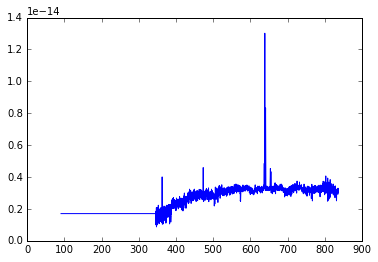

In [4]:
plt.plot(galaxies['spiral'].wavelen, galaxies['spiral'].flambda)

In [36]:
shift_size = 20  # nm shift in the r-band filter

throughPath = os.getenv('LSST_THROUGHPUTS_BASELINE')
keys = ['u','g','r','r_shifted', 'i','z','y']
filters = {}
for filtername in keys:
    bp = np.loadtxt(os.path.join(throughPath, 'filter_'+filtername[0]+'.dat'),
                    dtype=zip(['wave','trans'],[float]*2 ))
    #good = np.where(bp['trans'] > 1e-3)
    #bp = bp[good]
    tempB = Bandpass()
    if filtername == 'r_shifted':
        over = np.where(bp['wave'] > 650)
        bp['wave'][over] += shift_size
    tempB.setBandpass(bp['wave'],bp['trans'])
    filters[filtername] = tempB

In [37]:
galaxies['spiral'].calcMag(filters['i'])

There is an area of non-overlap between desired wavelength range (300.00 to 1150.00) and sed FromArray (90.91 to 837)


nan

In [38]:
# Need array of galaxy x filter x redshift.  Loop over redshifts, 
redshifts = np.arange(0,1.9,.01)
mags = np.zeros(redshifts.size, dtype=zip(['g','r','r_shifted', 'i'],[float]*4))
gtype = 'starburst'
for i,z in enumerate(redshifts):
    temp_wave, temp_flam = galaxies[gtype].redshiftSED(z, wavelen=galaxies[gtype].wavelen,
                                                          flambda=galaxies[gtype].flambda)
    temp_sed = Sed(wavelen=temp_wave, flambda=temp_flam)
    for key in mags.dtype.names:
        temp_bp = Bandpass()
        temp_bp.setBandpass(filters[key].wavelen, filters[key].sb, wavelen_min = temp_sed.wavelen.min()+1, 
                            wavelen_max = temp_sed.wavelen.max()-1)
        mags[i][key] = temp_sed.calcMag(temp_bp)

(660, 750)

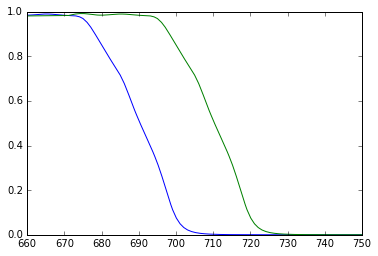

In [39]:
plt.plot(filters['r'].wavelen, filters['r'].sb)
plt.plot(filters['r_shifted'].wavelen, filters['r_shifted'].sb)
plt.xlim([660,750])

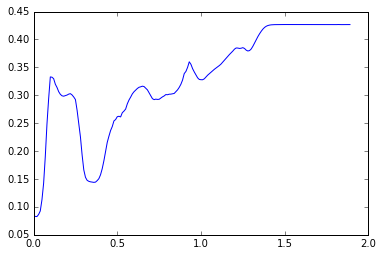

In [40]:
plt.plot(redshifts, mags['r']-mags['i'])

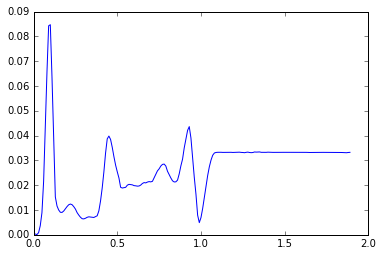

In [42]:
plt.plot(redshifts, mags['r']-mags['r_shifted'])
#plt.xlim([0,.2])

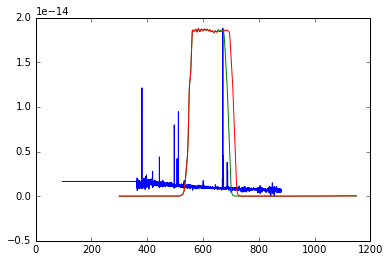

In [43]:
z=.05
temp_wave, temp_flam = galaxies[gtype].redshiftSED(z, wavelen=galaxies[gtype].wavelen,
                                                          flambda=galaxies[gtype].flambda)
plt.plot(temp_wave, temp_flam)
plt.plot(filters['r'].wavelen, filters['r'].sb*temp_flam.max())
plt.plot(filters['r_shifted'].wavelen, filters['r_shifted'].sb*temp_flam.max())

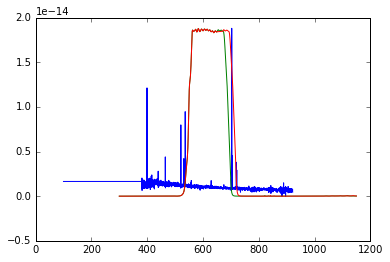

In [44]:
z=.10
temp_wave, temp_flam = galaxies[gtype].redshiftSED(z, wavelen=galaxies[gtype].wavelen,
                                                          flambda=galaxies[gtype].flambda)
plt.plot(temp_wave, temp_flam)
plt.plot(filters['r'].wavelen, filters['r'].sb*temp_flam.max())
plt.plot(filters['r_shifted'].wavelen, filters['r_shifted'].sb*temp_flam.max())

(600, 800)

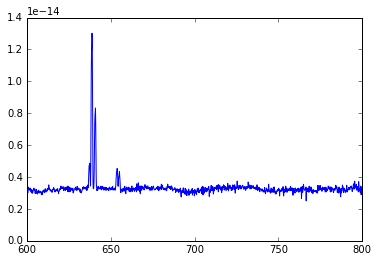

In [12]:
plt.plot(galaxies[gtype].wavelen, galaxies[gtype].flambda)
plt.xlim(600,800)